In [3]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

# import os
# for dirname, _, filenames in os.walk('/kaggle/input'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All"
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

# INSTALL

In [61]:
!pip install pulp -q
!pip install catboost -q

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.2/98.2 MB 9.4 MB/s eta 0:00:00


# IMPORTS

In [230]:
import matplotlib.pyplot as plt
from pulp import LpMaximize, LpProblem, LpVariable, lpSum, value
import pprint
import random
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
from xgboost import XGBRegressor
from catboost import CatBoostRegressor
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout


# Mount Drive

In [5]:
# colab
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Loading data

In [6]:
# # Kaggle
# MATCHES_PATH = "/kaggle/input/ipl-data-2008-2020/IPL-data/IPL Matches 2008-2020.csv"
# BALL_BY_BALL_PATH = '/kaggle/input/ipl-data-2008-2020/IPL-data/IPL Ball-by-Ball 2008-2020.csv'
# colab
MATCHES_PATH = "/content/drive/MyDrive/IPL-data/IPL Matches 2008-2020.csv"
BALL_BY_BALL_PATH = "/content/drive/MyDrive/IPL-data/IPL Ball-by-Ball 2008-2020.csv"

In [7]:
matches_df = pd.read_csv(MATCHES_PATH)
ball_by_ball_df = pd.read_csv(BALL_BY_BALL_PATH)

In [8]:
matches_df.head()

,id,city,date,player_of_match,venue,neutral_venue,team1,team2,toss_winner,toss_decision,winner,result,result_margin,eliminator,method,umpire1,umpire2
0,335982,Bangalore,2008-04-18,BB McCullum,M Chinnaswamy Stadium,0,Royal Challengers Bangalore,Kolkata Knight Riders,Royal Challengers Bangalore,field,Kolkata Knight Riders,runs,140.0,N,NaN,Asad Rauf,RE Koertzen
1,335983,Chandigarh,2008-04-19,MEK Hussey,"Punjab Cricket Association Stadium, Mohali",0,Kings XI Punjab,Chennai Super Kings,Chennai Super Kings,bat,Chennai Super Kings,runs,33.0,N,NaN,MR Benson,SL Shastri
2,335984,Delhi,2008-04-19,MF Maharoof,Feroz Shah Kotla,0,Delhi Daredevils,Rajasthan Royals,Rajasthan Royals,bat,Delhi Daredevils,wickets,9.0,N,NaN,Aleem Dar,GA Pratapkumar
3,335985,Mumbai,2008-04-20,MV Boucher,Wankhede Stadium,0,Mumbai Indians,Royal Challengers Bangalore,Mumbai Indians,bat,Royal Challengers Bangalore,wickets,5.0,N,NaN,SJ Davis,DJ Harper
4,335986,Kolkata,2008-04-20,DJ Hussey,Eden Gardens,0,Kolkata Knight Riders,Deccan Chargers,Deccan Chargers,bat,Kolkata Knight Riders,wickets,5.0,N,NaN,BF Bowden,K Hariharan


In [9]:
matches_df.shape

(816, 17)

In [10]:
matches_df.isna().sum()

id                   0
city                13
date                 0
player_of_match      4
venue                0
neutral_venue        0
team1                0
team2                0
toss_winner          0
toss_decision        0
winner               4
result               4
result_margin       17
eliminator           4
method             797
umpire1              0
umpire2              0
dtype: int64

In [11]:
ball_by_ball_df.head()

,id,inning,over,ball,batsman,non_striker,bowler,batsman_runs,extra_runs,total_runs,non_boundary,is_wicket,dismissal_kind,player_dismissed,fielder,extras_type,batting_team,bowling_team
0,335982,1,6,5,RT Ponting,BB McCullum,AA Noffke,1,0,1,0,0,NaN,NaN,NaN,NaN,Kolkata Knight Riders,Royal Challengers Bangalore
1,335982,1,6,6,BB McCullum,RT Ponting,AA Noffke,1,0,1,0,0,NaN,NaN,NaN,NaN,Kolkata Knight Riders,Royal Challengers Bangalore
2,335982,1,7,1,BB McCullum,RT Ponting,Z Khan,0,0,0,0,0,NaN,NaN,NaN,NaN,Kolkata Knight Riders,Royal Challengers Bangalore
3,335982,1,7,2,BB McCullum,RT Ponting,Z Khan,1,0,1,0,0,NaN,NaN,NaN,NaN,Kolkata Knight Riders,Royal Challengers Bangalore
4,335982,1,7,3,RT Ponting,BB McCullum,Z Khan,1,0,1,0,0,NaN,NaN,NaN,NaN,Kolkata Knight Riders,Royal Challengers Bangalore


In [12]:
ball_by_ball_df.shape

(193468, 18)

In [13]:
matches_df.columns

Index(['id', 'city', 'date', 'player_of_match', 'venue', 'neutral_venue',
       'team1', 'team2', 'toss_winner', 'toss_decision', 'winner', 'result',
       'result_margin', 'eliminator', 'method', 'umpire1', 'umpire2'],
      dtype='object')

In [14]:
ball_by_ball_df.columns

Index(['id', 'inning', 'over', 'ball', 'batsman', 'non_striker', 'bowler',
       'batsman_runs', 'extra_runs', 'total_runs', 'non_boundary', 'is_wicket',
       'dismissal_kind', 'player_dismissed', 'fielder', 'extras_type',
       'batting_team', 'bowling_team'],
      dtype='object')

In [15]:
ball_by_ball_df.isna().sum()

id                       0
inning                   0
over                     0
ball                     0
batsman                  0
non_striker              0
bowler                   0
batsman_runs             0
extra_runs               0
total_runs               0
non_boundary             0
is_wicket                0
dismissal_kind      183973
player_dismissed    183973
fielder             186684
extras_type         183235
batting_team             0
bowling_team           191
dtype: int64

In [16]:
ball_by_ball_df[ball_by_ball_df["bowling_team"].isna()]

,id,inning,over,ball,batsman,non_striker,bowler,batsman_runs,extra_runs,total_runs,non_boundary,is_wicket,dismissal_kind,player_dismissed,fielder,extras_type,batting_team,bowling_team
57048,501265,1,0,1,NV Ojha,DA Warner,AC Thomas,1,0,1,0,0,NaN,NaN,NaN,NaN,Delhi Daredevils,NaN
57049,501265,1,0,2,DA Warner,NV Ojha,AC Thomas,0,1,1,0,0,NaN,NaN,NaN,legbyes,Delhi Daredevils,NaN
57050,501265,1,1,1,DA Warner,NV Ojha,JP Faulkner,0,1,1,0,0,NaN,NaN,NaN,legbyes,Delhi Daredevils,NaN
57051,501265,1,1,2,NV Ojha,DA Warner,JP Faulkner,0,0,0,0,0,NaN,NaN,NaN,NaN,Delhi Daredevils,NaN
57052,501265,1,1,3,NV Ojha,DA Warner,JP Faulkner,0,0,0,0,0,NaN,NaN,NaN,NaN,Delhi Daredevils,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
115654,829763,1,7,3,AB de Villiers,Mandeep Singh,STR Binny,0,0,0,0,0,NaN,NaN,NaN,NaN,Royal Challengers Bangalore,NaN
115655,829763,1,8,6,AB de Villiers,Mandeep Singh,SR Watson,2,0,2,0,0,NaN,NaN,NaN,NaN,Royal Challengers Bangalore,NaN
115656,829763,1,9,1,Mandeep Singh,AB de Villiers,STR Binny,4,0,4,0,0,NaN,NaN,NaN,NaN,Royal Challengers Bangalore,NaN
115657,829763,1,8,4,AB de Villiers,Mandeep Singh,SR Watson,0,0,0,0,0,NaN,NaN,NaN,NaN,Royal Challengers Bangalore,NaN


# CLEANING

In [17]:
ball_by_ball_df = pd.read_csv(BALL_BY_BALL_PATH)
merged_df = pd.merge(ball_by_ball_df, matches_df[['id', 'team2']], on='id', how='left')
merged_df.fillna({'bowling_team' : merged_df['team2']},inplace = True)
merged_df.drop(columns=['team2'], inplace=True)
ball_by_ball_df = merged_df

In [18]:
ball_by_ball_df.isna().sum()

id                       0
inning                   0
over                     0
ball                     0
batsman                  0
non_striker              0
bowler                   0
batsman_runs             0
extra_runs               0
total_runs               0
non_boundary             0
is_wicket                0
dismissal_kind      183973
player_dismissed    183973
fielder             186684
extras_type         183235
batting_team             0
bowling_team             0
dtype: int64

In [19]:
ball_by_ball_df['player_dismissed']

0         NaN
1         NaN
2         NaN
3         NaN
4         NaN
         ... 
193463    NaN
193464    NaN
193465    NaN
193466    NaN
193467    NaN
Name: player_dismissed, Length: 193468, dtype: object

In [20]:
ball_by_ball_df['dismissal_kind'].unique()

array([nan, 'caught', 'run out', 'bowled', 'lbw', 'retired hurt',
       'stumped', 'caught and bowled', 'hit wicket',
       'obstructing the field'], dtype=object)

In [21]:
ball_by_ball_df[ball_by_ball_df['dismissal_kind'] == 'stumped']

,id,inning,over,ball,batsman,non_striker,bowler,batsman_runs,extra_runs,total_runs,non_boundary,is_wicket,dismissal_kind,player_dismissed,fielder,extras_type,batting_team,bowling_team
753,335985,1,16,5,RV Uthappa,AM Nayar,B Akhil,0,0,0,0,1,stumped,RV Uthappa,MV Boucher,NaN,Mumbai Indians,Royal Challengers Bangalore
1302,335987,1,7,4,DPMD Jayawardene,JR Hopes,D Salunkhe,0,0,0,0,1,stumped,DPMD Jayawardene,Kamran Akmal,NaN,Kings XI Punjab,Rajasthan Royals
1890,335990,1,2,2,AC Gilchrist,VVS Laxman,YK Pathan,0,0,0,0,1,stumped,AC Gilchrist,Kamran Akmal,NaN,Deccan Chargers,Rajasthan Royals
4820,336002,1,11,2,HH Gibbs,AC Gilchrist,A Kumble,0,0,0,0,1,stumped,HH Gibbs,SP Goswami,NaN,Deccan Chargers,Royal Challengers Bangalore
5004,336003,1,8,6,Yuvraj Singh,SE Marsh,Mohammad Hafeez,0,0,0,0,1,stumped,Yuvraj Singh,WP Saha,NaN,Kings XI Punjab,Kolkata Knight Riders
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
181567,1216502,2,10,6,WP Saha,KS Williamson,YS Chahal,0,0,0,0,1,stumped,WP Saha,AB de Villiers,NaN,Sunrisers Hyderabad,Royal Challengers Bangalore
183059,1216508,2,19,6,Shivam Mavi,Kuldeep Yadav,RD Chahar,0,0,0,0,1,stumped,Shivam Mavi,Q de Kock,NaN,Kolkata Knight Riders,Mumbai Indians
185979,1216521,1,8,5,DL Chahar,SM Curran,RD Chahar,0,0,0,0,1,stumped,DL Chahar,Q de Kock,NaN,Chennai Super Kings,Mumbai Indians
189456,1216535,1,10,2,SS Iyer,RR Pant,RD Chahar,0,0,0,0,1,stumped,SS Iyer,Q de Kock,NaN,Delhi Capitals,Mumbai Indians


In [22]:
ball_by_ball_df = ball_by_ball_df.sort_values(by=['id','inning','over','ball'])
ball_by_ball_df

,id,inning,over,ball,batsman,non_striker,bowler,batsman_runs,extra_runs,total_runs,non_boundary,is_wicket,dismissal_kind,player_dismissed,fielder,extras_type,batting_team,bowling_team
79,335982,1,0,1,SC Ganguly,BB McCullum,P Kumar,0,1,1,0,0,NaN,NaN,NaN,legbyes,Kolkata Knight Riders,Royal Challengers Bangalore
80,335982,1,0,2,BB McCullum,SC Ganguly,P Kumar,0,0,0,0,0,NaN,NaN,NaN,NaN,Kolkata Knight Riders,Royal Challengers Bangalore
81,335982,1,0,3,BB McCullum,SC Ganguly,P Kumar,0,1,1,0,0,NaN,NaN,NaN,wides,Kolkata Knight Riders,Royal Challengers Bangalore
82,335982,1,0,4,BB McCullum,SC Ganguly,P Kumar,0,0,0,0,0,NaN,NaN,NaN,NaN,Kolkata Knight Riders,Royal Challengers Bangalore
83,335982,1,0,5,BB McCullum,SC Ganguly,P Kumar,0,0,0,0,0,NaN,NaN,NaN,NaN,Kolkata Knight Riders,Royal Challengers Bangalore
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
193372,1237181,2,17,6,HH Pandya,Ishan Kishan,K Rabada,1,0,1,0,0,NaN,NaN,NaN,NaN,Mumbai Indians,Delhi Capitals
193373,1237181,2,18,1,HH Pandya,Ishan Kishan,A Nortje,1,0,1,0,0,NaN,NaN,NaN,NaN,Mumbai Indians,Delhi Capitals
193374,1237181,2,18,2,Ishan Kishan,HH Pandya,A Nortje,1,0,1,0,0,NaN,NaN,NaN,NaN,Mumbai Indians,Delhi Capitals
193375,1237181,2,18,3,HH Pandya,Ishan Kishan,A Nortje,0,0,0,0,1,caught,HH Pandya,AM Rahane,NaN,Mumbai Indians,Delhi Capitals


# Feature Engineering

## Batsman score-card summary

In [30]:
grouped_df = ball_by_ball_df.groupby(['id', 'batsman'])
batsman_summary = grouped_df.agg(
    runs=pd.NamedAgg(column='batsman_runs', aggfunc='sum'),
    fours=pd.NamedAgg(column='batsman_runs', aggfunc=lambda x: (x == 4).sum()),
    sixes=pd.NamedAgg(column='batsman_runs', aggfunc=lambda x: (x == 6).sum()),
    balls_faced=pd.NamedAgg(column='batsman_runs', aggfunc='count'),
    team=pd.NamedAgg(column='batting_team', aggfunc='first')
    # batting_team = pd.NamedAgg(column='batting_team', aggfunc='first'),
    # bowling_team=pd.NamedAgg(column='bowling_team', aggfunc='first')
)

# Bating Points
batsman_summary['strike_rate'] = (batsman_summary['runs'] / batsman_summary['balls_faced']) * 100

batsman_summary['batting_points'] = (
    batsman_summary['runs'] + batsman_summary['fours'] + batsman_summary['sixes'] * 2
)
batsman_summary['batting_points'] += (
    (batsman_summary['runs'] >= 100) * 8 +
    (batsman_summary['runs'] >= 50) * 4 +
    (batsman_summary['runs'] >= 30) * 4
)
batsman_summary.loc[batsman_summary['runs'] == 0, 'batting_points'] = -2

batsman_summary.reset_index(inplace = True)

batsman_summary.sort_values(by='batsman',inplace = True)
# Batsman points based on strike rate
batsman_summary['strike_rate_points'] = 0
batsman_summary.loc[batsman_summary['balls_faced'] > 10, 'strike_rate_points'] = (
    (batsman_summary['strike_rate'] > 170) * 6 +
    ((batsman_summary['strike_rate'] > 150) & (batsman_summary['strike_rate'] <= 170)) * 4 +
    ((batsman_summary['strike_rate'] >= 130) & (batsman_summary['strike_rate'] <= 150)) * 2 +
    ((batsman_summary['strike_rate'] >= 60) & (batsman_summary['strike_rate'] <= 70)) * -2 +
    ((batsman_summary['strike_rate'] >= 50) & (batsman_summary['strike_rate'] < 60)) * -4 +
    (batsman_summary['strike_rate'] < 50) * -6
)

# Total points
batsman_summary['batting_points'] += batsman_summary['strike_rate_points']

batsman_summary.drop(columns=['strike_rate_points'], inplace=True)


batsman_summary.head(5)


,id,batsman,runs,fours,sixes,balls_faced,team,strike_rate,batting_points
5213,598021,A Ashish Reddy,7,1,0,7,Sunrisers Hyderabad,100.000000,8
4747,548376,A Ashish Reddy,4,0,0,5,Deccan Chargers,80.000000,4
5341,598030,A Ashish Reddy,36,2,3,16,Sunrisers Hyderabad,225.000000,54
5370,598032,A Ashish Reddy,14,1,0,11,Sunrisers Hyderabad,127.272727,15
5539,598044,A Ashish Reddy,5,1,0,7,Sunrisers Hyderabad,71.428571,6


## Bowler score-card summary

In [23]:
# grouped = ball_by_ball_df.groupby(['id', 'inning', 'bowler', 'over'])

# is_maiden = grouped['total_runs'].sum().apply(lambda x: 1/6 if x == 0 else 0).reset_index()
# is_maiden.rename(columns={'total_runs': 'is_maiden'}, inplace=True)


# ball_by_ball_df = ball_by_ball_df.merge(is_maiden, on=['id', 'inning', 'bowler', 'over'], how='left')


In [24]:
# is_maiden.head()

In [ ]:
# ball_by_ball_df[ball_by_ball_df['is_maiden'] == 1/6]

In [94]:
grouped_df = ball_by_ball_df.groupby(['id','bowler'])
bowler_summary = grouped_df.agg(
    runs_conceded=pd.NamedAgg(column='total_runs', aggfunc='sum'),
    fours_conceded=pd.NamedAgg(column='total_runs', aggfunc=lambda x: ((x == 4) | (x == 5)).sum()),
    sixes_conceded=pd.NamedAgg(column='total_runs', aggfunc=lambda x: ((x == 6) | (x == 7)).sum()),
    wickets_taken=pd.NamedAgg(column='dismissal_kind', aggfunc=lambda x: x.isin(['caught','bowled', 'lbw','stumped', 'caught and bowled', 'hit wicket']).sum()),
    bowled_and_lbw =pd.NamedAgg(column='dismissal_kind', aggfunc=lambda x: x.isin(['bowled', 'lbw',]).sum()),
    balls_bowled=pd.NamedAgg(column='over', aggfunc='count'),
    team=pd.NamedAgg(column='bowling_team', aggfunc='first'),

    # maidens=pd.NamedAgg(column='is_maiden',aggfunc='sum')
    # batting_team = pd.NamedAgg(column='batting_team', aggfunc='first'),
    # bowling_team=pd.NamedAgg(column='bowling_team', aggfunc='first')
)
bowler_summary['bowling_average'] = bowler_summary['runs_conceded'] / bowler_summary['wickets_taken'].replace(0, 1)
bowler_summary['economy_rate'] = bowler_summary['runs_conceded'] / (bowler_summary['balls_bowled'] / 6).astype('int').replace(0, 1)

# Bowling points
bowler_summary['bowling_points'] = bowler_summary['wickets_taken']*25 + bowler_summary['bowled_and_lbw']*8

bowler_summary['bowling_points'] += (
    (bowler_summary['wickets_taken'] >= 5) * 8 +
    (bowler_summary['wickets_taken'] >= 4) * 4 +
    (bowler_summary['wickets_taken'] >= 3) * 4
)

# Bowling points based on economy rate
bowler_summary['economy_points'] = 0
bowler_summary.loc[bowler_summary['balls_bowled'] >= 12, 'economy_points'] = (
    (bowler_summary['economy_rate'] < 5) * 6 +
    ((bowler_summary['economy_rate'] >= 5) & (bowler_summary['economy_rate'] < 6)) * 4 +
    ((bowler_summary['economy_rate'] >= 6) & (bowler_summary['economy_rate'] < 7)) * 2 +
    ((bowler_summary['economy_rate'] >= 10) & (bowler_summary['economy_rate'] < 11)) * -2 +
    ((bowler_summary['economy_rate'] >= 11) & (bowler_summary['economy_rate'] < 12)) * -4 +
    (bowler_summary['economy_rate'] >= 12) * -6
)

# Calculate total bowling points
# bowler_summary['bowling_points'] += bowler_summary['economy_points']


bowler_summary.reset_index(inplace = True)
bowler_summary.sort_values(by='bowler',inplace = True)
# Drop the 'team' column
bowler_summary.drop(columns=['economy_points'], inplace=True)

bowler_summary.head(5)

,id,bowler,runs_conceded,fours_conceded,sixes_conceded,wickets_taken,bowled_and_lbw,balls_bowled,team,bowling_average,economy_rate,bowling_points
4448,598048,A Ashish Reddy,13,1,1,0,0,6,Sunrisers Hyderabad,13.0,13.000000,0
3468,548348,A Ashish Reddy,32,0,2,1,0,19,Deccan Chargers,32.0,10.666667,25
3442,548346,A Ashish Reddy,11,1,0,1,0,14,Deccan Chargers,11.0,5.500000,25
6223,980915,A Ashish Reddy,14,2,0,1,1,12,Sunrisers Hyderabad,14.0,7.000000,33
5609,829731,A Ashish Reddy,16,0,1,1,0,13,Sunrisers Hyderabad,16.0,8.000000,25


## Fielder summary

In [96]:
grouped_df = ball_by_ball_df.groupby(['id','fielder'])
fielder_summary = grouped_df.agg(
    stumps = pd.NamedAgg(column = 'dismissal_kind', aggfunc = lambda x: (x == 'stumped').sum()),
    run_outs = pd.NamedAgg(column = 'dismissal_kind', aggfunc = lambda x: (x == 'run out').sum()),
    catches = pd.NamedAgg(column = 'dismissal_kind', aggfunc = lambda x: (x == 'caught').sum()),
    team=pd.NamedAgg(column='bowling_team', aggfunc='first')
)

fielder_summary['fielding_points'] = fielder_summary['catches']*8 + fielder_summary['run_outs']*9 + fielder_summary['stumps']*12 + (fielder_summary['catches'] >=3)*4

fielder_summary.reset_index(inplace = True)


# Splitting 'fielder' column and creating new rows for each player
fielder_summary['fielder'] = fielder_summary['fielder'].str.split(',')
fielder_summary = fielder_summary.explode('fielder')

fielder_summary.sort_values(by = 'fielder',inplace = True)
# fielder_summary.rename(columns={'fielder': 'player'}, inplace=True)

fielder_summary.head(10)

,id,fielder,stumps,run_outs,catches,team,fielding_points
2280,598004,A Ashish Reddy,0,0,1,Sunrisers Hyderabad,8
2466,598030,A Ashish Reddy,0,0,1,Sunrisers Hyderabad,8
3744,980953,A Ashish Reddy,0,0,1,Sunrisers Hyderabad,8
2094,548359,A Ashish Reddy,0,1,0,Deccan Chargers,9
3379,829773,A Ashish Reddy,0,1,0,Sunrisers Hyderabad,9
2384,598018,A Ashish Reddy,0,0,2,Sunrisers Hyderabad,16
2327,598010,A Ashish Reddy,0,0,1,Sunrisers Hyderabad,8
2408,598021,A Ashish Reddy,0,0,1,Sunrisers Hyderabad,8
3201,829719,A Ashish Reddy,0,0,1,Sunrisers Hyderabad,8
2426,598023,A Chandila,0,0,1,Rajasthan Royals,8


## Generate Features

In [97]:
# fielder_df['date'] = pd.to_datetime(fielder_df['date'])
# fielder_df = fielder_df.sort_values(by=['bowler', 'date'])
# fielder_df.head()

In [98]:
# k = 3
# performances = []
# points = []
# for player, group in fielder_df.groupby('fielder'):
#   # Compute the rolling sum of points for the last k matches

#   for i in range(len(group)):
#     if i < k:
#       continue
#     performances.append(group[['catches','run_outs','stumps']].iloc[i-k:i].to_numpy().flatten())
#     points.append(group['fielding_points'].iloc[i])

#   # print(player)
#   # print(group)
#   # print(performances[0])
#   # print(points[0])
#   # print(performances[1])
#   # print(points[1])
# print(len(performances))
# print(len(points))
#   # break


In [99]:
# print(type(performances[0]))
# print(performances[0])

In [100]:
# np.array(performances).shape

In [101]:
# np.array(points).shape

## FIELDING FEATURES

In [102]:
def generateFeats_fielder(summary_df, matches_df, k,flat = True):
    """
    Generate features and target pair: performance from last k matches, points
    """
    # Merge with matches to get dates
    summary_df = pd.merge(summary_df, matches_df[['id', 'date']], how='left', on='id')
    # Convert date column to datetime
    summary_df['date'] = pd.to_datetime(summary_df['date'])
    # Sort by player name and dates
    summary_df = summary_df.sort_values(by=['fielder', 'date'])
    performances = []
    points = []
    for player, group in summary_df.groupby('fielder'):
        for i in range(len(group)):
            if i < k:
                continue
            if flat:
                performances.append(group[['catches','run_outs','stumps']].iloc[i-k:i].to_numpy().flatten())
            else:
                performances.append(group[['catches','run_outs','stumps']].iloc[i-k:i].to_numpy())

            points.append(group['fielding_points'].iloc[i])


    performances_np = np.array(performances)
    points_np = np.array(points)
    return (performances_np,points_np)


In [103]:
(fielder_performance,fielder_points) = generateFeats_fielder(fielder_summary,matches_df,5)

In [104]:
print(fielder_performance.shape,fielder_points.shape)

(4053, 15) (4053,)


In [105]:
fielder_performance[0].reshape(5,-1)

array([[0, 1, 0],
       [1, 0, 0],
       [1, 0, 0],
       [2, 0, 0],
       [1, 0, 0]])

## BATTING FEATURES

In [106]:
def generateFeats_batsman(summary_df, matches_df, k,flat = True):
    """
    Generate features and target pair: performance from last k matches, points
    """
    # Merge with matches to get dates
    summary_df = pd.merge(summary_df, matches_df[['id', 'date']], how='left', on='id')
    # Convert date column to datetime
    summary_df['date'] = pd.to_datetime(summary_df['date'])
    # Sort by player name and dates
    summary_df = summary_df.sort_values(by=['batsman', 'date'])
    performances = []
    points = []
    for player, group in summary_df.groupby('batsman'):
        for i in range(len(group)):
            if i < k:
                continue

            if flat:
                performances.append(group[['runs','fours','sixes','balls_faced','strike_rate']].iloc[i-k:i].to_numpy().flatten())
            else:
                performances.append(group[['runs','fours','sixes','balls_faced','strike_rate']].iloc[i-k:i].to_numpy())

            points.append(group['batting_points'].iloc[i])

    performances_np = np.array(performances)
    points_np = np.array(points)


    return (performances_np,points_np)


In [107]:
(batsman_performance,batsman_points) = generateFeats_batsman(batsman_summary,matches_df,5)

In [108]:
print(batsman_performance.shape,batsman_points.shape)

(10019, 25) (10019,)


## BOWLING FEATURES

In [109]:
def generateFeats_bowler(summary_df, matches_df, k,flat = True):
    """
    Generate features and target pair: performance from last k matches, points
    """
    # Merge with matches to get dates
    summary_df = pd.merge(summary_df, matches_df[['id', 'date']], how='left', on='id')
    # Convert date column to datetime
    summary_df['date'] = pd.to_datetime(summary_df['date'])
    # Sort by player name and dates
    summary_df = summary_df.sort_values(by=['bowler', 'date'])
    performances = []
    points = []
    for player, group in summary_df.groupby('bowler'):
        for i in range(len(group)):
            if i < k:
                continue

            if flat:
                performances.append(group[['runs_conceded','fours_conceded','sixes_conceded','wickets_taken','bowled_and_lbw','balls_bowled','bowling_average','economy_rate']].iloc[i-k:i].to_numpy().flatten())
            else:
                performances.append(group[['runs_conceded','fours_conceded','sixes_conceded','wickets_taken','bowled_and_lbw','balls_bowled','bowling_average','economy_rate']].iloc[i-k:i].to_numpy())

            points.append(group['bowling_points'].iloc[i])

    performances_np = np.array(performances)
    points_np = np.array(points)


    return (performances_np,points_np)

In [110]:
(bowler_performance,bowler_points) = generateFeats_bowler(bowler_summary,matches_df,5)

In [111]:
print(bowler_performance.shape,bowler_points.shape)

(7926, 40) (7926,)


## Correlation

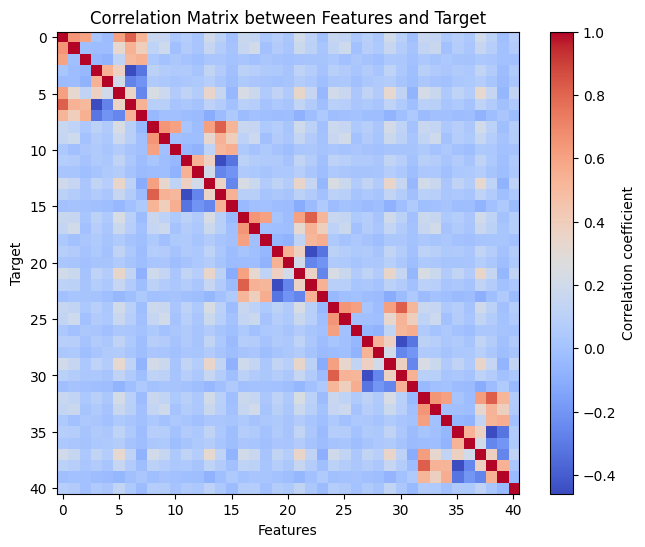

In [112]:
feature_target_corr = np.corrcoef(bowler_performance.T, bowler_points)

# Plot the correlation matrix
plt.figure(figsize=(8, 6))
plt.imshow(feature_target_corr, cmap='coolwarm', interpolation='nearest')
plt.colorbar(label='Correlation coefficient')
plt.title('Correlation Matrix between Features and Target')
plt.xlabel('Features')
plt.ylabel('Target')
# plt.xticks(np.arange(120 + 1), ['Target'] + [f'Feature {i}' for i in range(1, 120 + 1)])
# plt.yticks(np.arange(120 + 1), ['Target'] + [f'Feature {i}' for i in range(1, 120 + 1)])
plt.show()

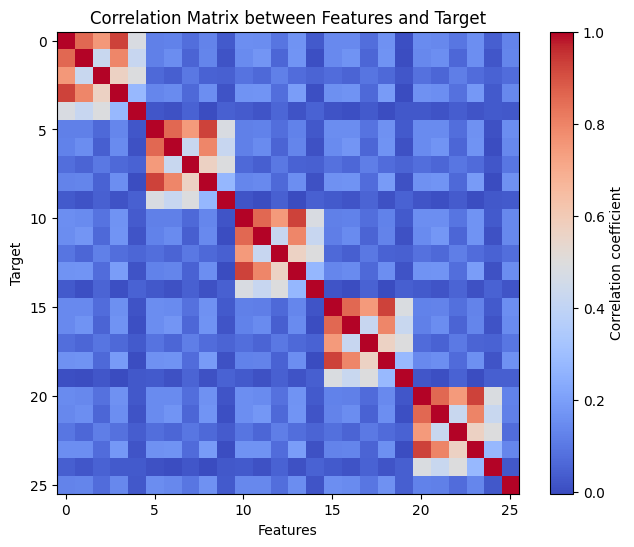

In [113]:
feature_target_corr = np.corrcoef(batsman_performance.T, batsman_points)

# Plot the correlation matrix
plt.figure(figsize=(8, 6))
plt.imshow(feature_target_corr, cmap='coolwarm', interpolation='nearest')
plt.colorbar(label='Correlation coefficient')
plt.title('Correlation Matrix between Features and Target')
plt.xlabel('Features')
plt.ylabel('Target')
# plt.xticks(np.arange(120 + 1), ['Target'] + [f'Feature {i}' for i in range(1, 120 + 1)])
# plt.yticks(np.arange(120 + 1), ['Target'] + [f'Feature {i}' for i in range(1, 120 + 1)])
plt.show()

# Player Selection

In [323]:
from pulp import LpMaximize, LpProblem, LpVariable, lpSum, value

class PlayerSelectionModule:
    def __init__(self, models, player_data, k,lstm = False):
        self.k = k
        self.lstm = lstm
        # Models for points prediction
        self.batsman_model = models['batsman']
        self.bowler_model = models['bowler']
        self.fielder_model = models['fielder']
        # Player data
        self.player_data = {player_type: pd.merge(player_data[player_type], matches_df[['id', 'date']], how='left', on='id').sort_values(by=[player_type, 'date'], ascending=False) for player_type in ['batsman', 'bowler', 'fielder']}
        # Features
        self.BATSMAN_FEATURES = ['runs', 'fours', 'sixes', 'balls_faced', 'strike_rate']
        self.BOWLER_FEATURES = ['runs_conceded', 'fours_conceded', 'sixes_conceded', 'wickets_taken', 'bowled_and_lbw', 'balls_bowled', 'bowling_average', 'economy_rate']
        self.FIELDER_FEATURES = ['catches', 'run_outs', 'stumps']

    def predict_points(self, player, player_type):
        performances = self.player_data[player_type][self.player_data[player_type][player_type] == player].head(self.k)
        if performances.empty:
            return 0

        features = performances[self.get_features(player_type)].to_numpy()
        if features.shape[0] < self.k:
            num_rows = features.shape[0]
            average_row = np.mean(features, axis=0)
            rows_to_add = 5 - num_rows
            new_rows = np.tile(average_row, (rows_to_add, 1))
            features = np.vstack((features, new_rows))

        if not self.lstm:
            features = features.flatten().reshape(1,-1)
            # print(features)
            if player_type == 'batsman':
                return self.batsman_model.predict(features)[0]
            elif player_type == 'bowler':
                return self.bowler_model.predict(features)[0]
            elif player_type == 'fielder':
                return self.fielder_model.predict(features)[0]
        else:
            features = np.array([features])
            # print(features)
            if player_type == 'batsman':
                return self.batsman_model.predict(features)[0][0]
            elif player_type == 'bowler':
                return self.bowler_model.predict(features)[0][0]
            elif player_type == 'fielder':
                return self.fielder_model.predict(features)[0][0]

    def get_features(self, player_type):
        if player_type == 'batsman':
            return self.BATSMAN_FEATURES
        elif player_type == 'bowler':
            return self.BOWLER_FEATURES
        elif player_type == 'fielder':
            return self.FIELDER_FEATURES

    def evaluate_players(self, players_list,player_costs):
        predicted_points = []
        for player in players_list:
            predicted_points.append({
                'name': player,
                'batting_points': self.predict_points(player, 'batsman'),
                'bowling_points': self.predict_points(player, 'bowler'),
                'fielder_points': self.predict_points(player, 'fielder'),
                'cost': player_costs[player],
                'selected': False,
                'selected_as': ''
            })

        return predicted_points

    def select_team(self,players_list,player_costs):
        players_data = self.evaluate_players(players_list,player_costs)
        # pprint.pprint(players_data)
        # LP problem
        N = len(players_data)
        Budget = 100
        prob = LpProblem("Example_Problem", LpMaximize)
        batsman_selected = [LpVariable(f'batsman_selected_{i}',cat = "Binary") for i in range(N)]
        bowler_selected = [LpVariable(f'bowler_selected_{i}',cat = "Binary") for i in range(N)]
        allrounder_selected = [LpVariable(f'allrounder_selected_{i}',cat = "Binary") for i in range(N)]

        selected = [batsman_selected[i] + bowler_selected[i] + allrounder_selected[i] for i in range(N)]
        for i in range(N):
            prob += selected[i] <= 1
            prob += selected[i] >= 0

        prob += lpSum(selected) == 11

        # to be optimized
        prob += lpSum(
                [((batsman_selected[i] * (players_data[i]['batting_points'] + players_data[i]['fielder_points'])) +
                (bowler_selected[i] * (players_data[i]['bowling_points'] + players_data[i]['fielder_points'])) +
                (allrounder_selected[i] * (players_data[i]['bowling_points'] + players_data[i]['fielder_points'] + players_data[i]['batting_points'])))
                for i in range(N)])

        prob += lpSum([selected[i] * players_data[i]['cost'] for i in range(N)]) <= Budget

        prob += lpSum(batsman_selected) >= 3
        prob += lpSum(batsman_selected) <= 6
        prob += lpSum(bowler_selected) >= 3
        prob += lpSum(bowler_selected) <= 6
        prob += lpSum(allrounder_selected) >= 1
        prob += lpSum(allrounder_selected) <= 4
        prob.solve()

        for i in range(N):
            if selected[i].value() == 1:
                players_data[i]['selected'] = True
                if batsman_selected[i].value() == 1:
                    players_data[i]['selected_as'] = 'batsman'
                elif bowler_selected[i].value() == 1:
                    players_data[i]['selected_as'] = 'bowler'
                elif allrounder_selected[i].value() == 1:
                    players_data[i]['selected_as'] = 'all rounder'
                continue

        return players_data




## List of all players

In [115]:
ALL_PLAYERS = list(set(batsman_summary['batsman'].unique()).union(
    set(bowler_summary['bowler']),
    set(fielder_summary['fielder'])
))
ALL_PLAYERS.sort()
len(ALL_PLAYERS)

653

# puLP

## puLP with random data

In [116]:
def generate_points():
    return {
        "batting_points": random.randint(0, 100),
        "bowling_points": random.randint(0, 100),
        "fielder_points": random.randint(0, 100),
        "cost": round(random.uniform(5, 10), 2),
        'selected': False,# Random cost between 0.5 and 2.5
    }

# Generate data for 22 players
players_data = []
for i in range(22):
    player_data = generate_points()
    players_data.append(player_data)


for i, player_data in enumerate(players_data, start=1):
    print(f"Player {i}: {player_data}")




Player 1: {'batting_points': 28, 'bowling_points': 40, 'fielder_points': 27, 'cost': 5.86, 'selected': False}
Player 2: {'batting_points': 30, 'bowling_points': 72, 'fielder_points': 92, 'cost': 7.11, 'selected': False}
Player 3: {'batting_points': 67, 'bowling_points': 43, 'fielder_points': 36, 'cost': 9.34, 'selected': False}
Player 4: {'batting_points': 62, 'bowling_points': 66, 'fielder_points': 13, 'cost': 6.57, 'selected': False}
Player 5: {'batting_points': 69, 'bowling_points': 54, 'fielder_points': 27, 'cost': 7.82, 'selected': False}
Player 6: {'batting_points': 9, 'bowling_points': 4, 'fielder_points': 7, 'cost': 7.7, 'selected': False}
Player 7: {'batting_points': 2, 'bowling_points': 100, 'fielder_points': 72, 'cost': 9.4, 'selected': False}
Player 8: {'batting_points': 16, 'bowling_points': 47, 'fielder_points': 66, 'cost': 9.47, 'selected': False}
Player 9: {'batting_points': 44, 'bowling_points': 18, 'fielder_points': 38, 'cost': 9.08, 'selected': False}
Player 10: {'ba

In [117]:

N = 22
Budget = 100
prob = LpProblem("Example_Problem", LpMaximize)
batsman_selected = [LpVariable(f'batsman_selected_{i}',cat = "Binary") for i in range(N)]
bowler_selected = [LpVariable(f'bowler_selected_{i}',cat = "Binary") for i in range(N)]
allrounder_selected = [LpVariable(f'allrounder_selected_{i}',cat = "Binary") for i in range(N)]

selected = [batsman_selected[i] + bowler_selected[i] + allrounder_selected[i] for i in range(N)]
for i in range(N):
    prob += selected[i] <= 1
    prob += selected[i] >= 0

prob += lpSum(selected) == 11

# to be optimized
prob += lpSum(
        [((batsman_selected[i] * (players_data[i]['batting_points'] + players_data[i]['fielder_points'])) +
        (bowler_selected[i] * (players_data[i]['bowling_points'] + players_data[i]['fielder_points'])) +
        (allrounder_selected[i] * (players_data[i]['bowling_points'] + players_data[i]['fielder_points'] + players_data[i]['batting_points'])))
         for i in range(N)])

prob += lpSum([selected[i] * players_data[i]['cost'] for i in range(N)]) <= Budget

prob += lpSum(batsman_selected) >= 3
prob += lpSum(batsman_selected) <= 6
prob += lpSum(bowler_selected) >= 3
prob += lpSum(bowler_selected) <= 6
prob += lpSum(allrounder_selected) >= 1
prob += lpSum(allrounder_selected) <= 4


prob.solve()
print([selected[i].value() for i in range(N)])
print([batsman_selected[i].value() for i in range(N)])
print([bowler_selected[i].value() for i in range(N)])
print([allrounder_selected[i].value() for i in range(N)])
for i in range(N):
    if selected[i].value() == 1:
        players_data[i]['selected'] = True
        if batsman_selected[i].value() == 1:
            players_data[i]['selected_as'] = 'batsman'
        elif bowler_selected[i].value() == 1:
            players_data[i]['selected_as'] = 'bowler'
        elif allrounder_selected[i].value() == 1:
            players_data[i]['selected_as'] = 'all rounder'
        continue

print(f'number of players selected: {len([player for player in players_data if player["selected"]])}')
pprint.pprint([player for player in players_data if player['selected']])

[0.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0]
[0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0]
[0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
[0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0]
number of players selected: 11
[{'batting_points': 30,
  'bowling_points': 72,
  'cost': 7.11,
  'fielder_points': 92,
  'selected': True,
  'selected_as': 'bowler'},
 {'batting_points': 67,
  'bowling_points': 43,
  'cost': 9.34,
  'fielder_points': 36,
  'selected': True,
  'selected_as': 'batsman'},
 {'batting_points': 69,
  'bowling_points': 54,
  'cost': 7.82,
  'fielder_points': 27,
  'selected': True,
  'selected_as': 'all rounder'},
 {'batting_points': 2,
  'bowling_points': 100,
  'cost': 9.4,
  'fielder_points': 72,
  'selected': True,
  's

## puLP with real match data

In [118]:
match_id = 1237181

In [182]:
def get_best_team(match_id,match_df,batsman_summary,bowler_summary,fielder_summary):
    players_data = []
    players_cost = {}
    players = list(set(batsman_summary[batsman_summary['id'] == match_id]['batsman'].unique()).union(
        set(bowler_summary[bowler_summary['id'] == match_id]['bowler']),
        set(fielder_summary[fielder_summary['id'] == match_id]['fielder'])))

    for player in players:
        cost = int(random.uniform(5, 10))
        if player in batsman_summary[batsman_summary['id'] == match_id]['batsman'].values:
            batting_points = int(batsman_summary[(batsman_summary['id'] == match_id) & (batsman_summary['batsman'] == player)]['batting_points'].iloc[0])
        else:
            batting_points = 0

        if player in bowler_summary[bowler_summary['id'] == match_id]['bowler'].values:
            bowling_points = int(bowler_summary[(bowler_summary['id'] == match_id) & (bowler_summary['bowler'] == player)]['bowling_points'].iloc[0])
        else:
            bowling_points = 0

        if player in fielder_summary[fielder_summary['id'] == match_id]['fielder'].values:
            fielding_points = int(fielder_summary[(fielder_summary['id'] == match_id) & (fielder_summary['fielder'] == player)]['fielding_points'].iloc[0])
        else:
            fielding_points = 0

        players_cost[player] = cost
        players_data.append({
            'name': player,
            'batting_points': batting_points,
            'bowling_points': bowling_points,
            'fielder_points': fielding_points,
            'cost': cost,
            'selected': False,
            'selected_as': '',
        })

    N = len(players)
    Budget = 100
    prob = LpProblem("Example_Problem", LpMaximize)
    batsman_selected = [LpVariable(f'batsman_selected_{i}',cat = "Binary") for i in range(N)]
    bowler_selected = [LpVariable(f'bowler_selected_{i}',cat = "Binary") for i in range(N)]
    allrounder_selected = [LpVariable(f'allrounder_selected_{i}',cat = "Binary") for i in range(N)]

    selected = [batsman_selected[i] + bowler_selected[i] + allrounder_selected[i] for i in range(N)]
    for i in range(N):
        prob += selected[i] <= 1
        prob += selected[i] >= 0

    prob += lpSum(selected) == 11

    # to be optimized
    prob += lpSum(
            [((batsman_selected[i] * (players_data[i]['batting_points'] + players_data[i]['fielder_points'])) +
            (bowler_selected[i] * (players_data[i]['bowling_points'] + players_data[i]['fielder_points'])) +
            (allrounder_selected[i] * (players_data[i]['bowling_points'] + players_data[i]['fielder_points'] + players_data[i]['batting_points'])))
             for i in range(N)])

    prob += lpSum([selected[i] * players_data[i]['cost'] for i in range(N)]) <= Budget

    prob += lpSum(batsman_selected) >= 3
    prob += lpSum(batsman_selected) <= 6
    prob += lpSum(bowler_selected) >= 3
    prob += lpSum(bowler_selected) <= 6
    prob += lpSum(allrounder_selected) >= 1
    prob += lpSum(allrounder_selected) <= 4


    prob.solve()
    print([selected[i].value() for i in range(N)])
    print([batsman_selected[i].value() for i in range(N)])
    print([bowler_selected[i].value() for i in range(N)])
    print([allrounder_selected[i].value() for i in range(N)])
    for i in range(N):
        if selected[i].value() == 1:
            players_data[i]['selected'] = True
            if batsman_selected[i].value() == 1:
                players_data[i]['selected_as'] = 'batsman'
            elif bowler_selected[i].value() == 1:
                players_data[i]['selected_as'] = 'bowler'
            elif allrounder_selected[i].value() == 1:
                players_data[i]['selected_as'] = 'all rounder'
            continue

    return players_data,players_cost



In [183]:
all_players_data,players_cost = get_best_team(1237181,matches_df,batsman_summary,bowler_summary,fielder_summary)
# pprint.pprint(l1)
# pprint.pprint(l2)


[0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0]
[0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0]
[0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0]
[0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]


In [121]:
# pprint.pprint([player for player in players_data if player['selected']])

In [184]:
df1 = pd.DataFrame([player for player in players_data if player['selected']])
df1

,name,batting_points,bowling_points,fielder_points,cost,selected,selected_as
0,Ishan Kishan,48,0,0,6,True,batsman
1,TA Boult,0,79,0,6,True,bowler
2,J Yadav,0,33,0,8,True,all rounder
3,SS Iyer,83,0,0,5,True,batsman
4,NM Coulter-Nile,0,50,8,8,True,bowler
5,K Rabada,0,33,0,5,True,all rounder
6,RR Pant,74,0,8,9,True,batsman
7,A Nortje,0,50,0,6,True,bowler
8,Q de Kock,29,0,16,7,True,all rounder
9,RG Sharma,91,0,0,8,True,batsman


In [337]:
df2 = pd.DataFrame(players_data)
df2['total'] = df2['batting_points'] + df2['bowling_points'] + df2['fielder_points']
df2

,name,batting_points,bowling_points,fielder_points,cost,selected,selected_as,total
0,KH Pandya,1,0,0,9,False,,1
1,Ishan Kishan,48,0,0,6,True,batsman,48
2,TA Boult,0,79,0,6,True,bowler,79
3,J Yadav,0,33,0,8,True,all rounder,33
4,R Ashwin,0,0,0,6,False,,0
5,JJ Bumrah,0,0,0,8,False,,0
6,S Dhawan,18,0,0,9,False,,18
7,SA Yadav,22,0,0,5,False,,22
8,SS Iyer,83,0,0,5,True,batsman,83
9,NM Coulter-Nile,0,50,8,8,True,bowler,58


# Regression models


## Train Test Split

### LSTM

In [233]:
(X_batting_lstm,y_batting_lstm) = generateFeats_batsman(batsman_summary,matches_df,5,flat=False)
(X_bowling_lstm,y_bowling_lstm) = generateFeats_bowler(bowler_summary,matches_df,5,flat=False)
(X_fielding_lstm,y_fielding_lstm) = generateFeats_fielder(fielder_summary,matches_df,5,flat=False)

In [234]:
X_batting_train_lstm, X_batting_test_lstm, y_batting_train_lstm, y_batting_test_lstm = train_test_split(X_batting_lstm, y_batting_lstm, test_size=0.2, random_state=42)
X_bowling_train_lstm, X_bowling_test_lstm, y_bowling_train_lstm, y_bowling_test_lstm = train_test_split(X_bowling_lstm, y_bowling_lstm, test_size=0.2, random_state=42)
X_fielding_train_lstm, X_fielding_test_lstm, y_fielding_train_lstm, y_fielding_test_lstm = train_test_split(X_fielding_lstm, y_fielding_lstm, test_size=0.2, random_state=42)

### flat

In [235]:
(X_batting,y_batting) = generateFeats_batsman(batsman_summary,matches_df,5)
(X_bowling,y_bowling) = generateFeats_bowler(bowler_summary,matches_df,5)
(X_fielding,y_fielding) = generateFeats_fielder(fielder_summary,matches_df,5)
print(X_batting.shape,y_batting.shape)
print(X_bowling.shape,y_bowling.shape)
print(X_fielding.shape,y_fielding.shape)

(10019, 25) (10019,)
(7926, 40) (7926,)
(4053, 15) (4053,)


In [236]:
X_batting_train, X_batting_test, y_batting_train, y_batting_test = train_test_split(X_batting, y_batting, test_size=0.2, random_state=42)
X_bowling_train, X_bowling_test, y_bowling_train, y_bowling_test = train_test_split(X_bowling, y_bowling, test_size=0.2, random_state=42)
X_fielding_train, X_fielding_test, y_fielding_train, y_fielding_test = train_test_split(X_fielding, y_fielding, test_size=0.2, random_state=42)


## Linear regression

### Train

In [139]:
# Initialize and train Linear Regression for batting
lr_batting = LinearRegression()
lr_batting.fit(X_batting_train, y_batting_train)

# Initialize and train Linear Regression for bowling
lr_bowling = LinearRegression()
lr_bowling.fit(X_bowling_train, y_bowling_train)

# Initialize and train Linear Regression for fielding
lr_fielding = LinearRegression()
lr_fielding.fit(X_fielding_train, y_fielding_train)

LinearRegression()

### Test

(2004, 25)

In [140]:
# Predictions
batting_predictions_lr = lr_batting.predict(X_batting_test)
bowling_predictions_lr = lr_bowling.predict(X_bowling_test)
fielding_predictions_lr = lr_fielding.predict(X_fielding_test)

# Calculate mean squared error for batting predictions using Linear Regression
mse_batting_lr = mean_squared_error(y_batting_test, batting_predictions_lr)

# Calculate mean squared error for bowling predictions using Linear Regression
mse_bowling_lr = mean_squared_error(y_bowling_test, bowling_predictions_lr)

# Calculate mean squared error for fielding predictions using Linear Regression
mse_fielding_lr = mean_squared_error(y_fielding_test, fielding_predictions_lr)

print("Mean Squared Error (Batting) - Linear Regression:", mse_batting_lr)
print("Mean Squared Error (Bowling) - Linear Regression:", mse_bowling_lr)
print("Mean Squared Error (Fielding) - Linear Regression:", mse_fielding_lr)


Mean Squared Error (Batting) - Linear Regression: 854.0771689258761
Mean Squared Error (Bowling) - Linear Regression: 764.7989073994161
Mean Squared Error (Fielding) - Linear Regression: 22.6457788674593


## Random Forest

### Train

In [148]:
# Initializing and training Random Forest regressor for batting
rf_batting = RandomForestRegressor()
rf_batting.fit(X_batting_train, y_batting_train)

# Initializing and training Random Forest regressor for bowling
rf_bowling = RandomForestRegressor()
rf_bowling.fit(X_bowling_train, y_bowling_train)

# Initializing and training Random Forest regressor for fielding
rf_fielding = RandomForestRegressor()
rf_fielding.fit(X_fielding_train, y_fielding_train)



RandomForestRegressor()

### Evaluate

In [149]:
# Predictions
batting_predictions = rf_batting.predict(X_batting_test)
bowling_predictions = rf_bowling.predict(X_bowling_test)
fielding_predictions = rf_fielding.predict(X_fielding_test)
# Calculate mean squared error for batting predictions
mse_batting = mean_squared_error(y_batting_test, batting_predictions)

# Calculate mean squared error for bowling predictions
mse_bowling = mean_squared_error(y_bowling_test, bowling_predictions)

# Calculate mean squared error for fielding predictions
mse_fielding = mean_squared_error(y_fielding_test, fielding_predictions)

print("Mean Squared Error (Batting):", mse_batting)
print("Mean Squared Error (Bowling):", mse_bowling)
print("Mean Squared Error (Fielding):", mse_fielding)


Mean Squared Error (Batting): 875.381907235529
Mean Squared Error (Bowling): 796.6286296343001
Mean Squared Error (Fielding): 26.93015228340622


## XGBoost

### Train

In [150]:

# Initialize and train XGBoost Regressor for batting
xgb_batting = XGBRegressor()
xgb_batting.fit(X_batting_train, y_batting_train)

# Initialize and train XGBoost Regressor for bowling
xgb_bowling = XGBRegressor()
xgb_bowling.fit(X_bowling_train, y_bowling_train)

# Initialize and train XGBoost Regressor for fielding
xgb_fielding = XGBRegressor()
xgb_fielding.fit(X_fielding_train, y_fielding_train)




XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=None, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

### Evaluate

In [151]:
# Predictions
batting_predictions_xgb = xgb_batting.predict(X_batting_test)
bowling_predictions_xgb = xgb_bowling.predict(X_bowling_test)
fielding_predictions_xgb = xgb_fielding.predict(X_fielding_test)

# Calculate mean squared error for batting predictions using XGBoost Regressor
mse_batting_xgb = mean_squared_error(y_batting_test, batting_predictions_xgb)

# Calculate mean squared error for bowling predictions using XGBoost Regressor
mse_bowling_xgb = mean_squared_error(y_bowling_test, bowling_predictions_xgb)

# Calculate mean squared error for fielding predictions using XGBoost Regressor
mse_fielding_xgb = mean_squared_error(y_fielding_test, fielding_predictions_xgb)

print("Mean Squared Error (Batting) - XGBoost:", mse_batting_xgb)
print("Mean Squared Error (Bowling) - XGBoost:", mse_bowling_xgb)
print("Mean Squared Error (Fielding) - XGBoost:", mse_fielding_xgb)

Mean Squared Error (Batting) - XGBoost: 997.4962402002925
Mean Squared Error (Bowling) - XGBoost: 886.0262351060221
Mean Squared Error (Fielding) - XGBoost: 27.798729429790917


## Catboost

### Train

In [158]:

# Initialize and train CatBoost Regressor for batting
catboost_batting = CatBoostRegressor(verbose = 0)
catboost_batting.fit(X_batting_train, y_batting_train)

# Initialize and train CatBoost Regressor for bowling
catboost_bowling = CatBoostRegressor(verbose = 0)
catboost_bowling.fit(X_bowling_train, y_bowling_train)

# Initialize and train CatBoost Regressor for fielding
catboost_fielding = CatBoostRegressor(verbose = 0)
catboost_fielding.fit(X_fielding_train, y_fielding_train)



### Test

In [159]:
# Predictions
batting_predictions_catboost = catboost_batting.predict(X_batting_test)
bowling_predictions_catboost = catboost_bowling.predict(X_bowling_test)
fielding_predictions_catboost = catboost_fielding.predict(X_fielding_test)

# Calculate mean squared error for batting predictions using CatBoost Regressor
mse_batting_catboost = mean_squared_error(y_batting_test, batting_predictions_catboost)

# Calculate mean squared error for bowling predictions using CatBoost Regressor
mse_bowling_catboost = mean_squared_error(y_bowling_test, bowling_predictions_catboost)

# Calculate mean squared error for fielding predictions using CatBoost Regressor
mse_fielding_catboost = mean_squared_error(y_fielding_test, fielding_predictions_catboost)

print("Mean Squared Error (Batting) - CatBoost:", mse_batting_catboost)
print("Mean Squared Error (Bowling) - CatBoost:", mse_bowling_catboost)
print("Mean Squared Error (Fielding) - CatBoost:", mse_fielding_catboost)


Mean Squared Error (Batting) - CatBoost: 889.9964151321506
Mean Squared Error (Bowling) - CatBoost: 796.7476123116367
Mean Squared Error (Fielding) - CatBoost: 24.833733432949018


## LSTM

In [237]:
X_batting_test_lstm.shape
X_bowling_test_lstm.shape


(1586, 5, 8)

### Train

In [314]:
def create_lstm_model(input_shape):
    model = Sequential()
    model.add(LSTM(units=50, return_sequences=True, input_shape=input_shape))
    model.add(LSTM(units=50))
    model.add(Dense(units=1))
    model.compile(optimizer='adam', loss='mean_squared_error')
    return model

# Assuming input shapes for batting, bowling, and fielding data
input_shape_batting = (5, 5)  # Example input shape for batting data
input_shape_bowling = (5, 8)  # Example input shape for bowling data
input_shape_fielding = (5, 3)  # Example input shape for fielding data

# Create LSTM models for batting, bowling, and fielding
model_lstm_batting = create_lstm_model(input_shape_batting)
model_lstm_bowling = create_lstm_model(input_shape_bowling)
model_lstm_fielding = create_lstm_model(input_shape_fielding)

# Print model summaries
print("Batting LSTM Model Summary:")
model_lstm_batting.summary()

print("\nBowling LSTM Model Summary:")
model_lstm_bowling.summary()

print("\nFielding LSTM Model Summary:")
model_lstm_fielding.summary()


Batting LSTM Model Summary:
Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_20 (LSTM)              (None, 5, 50)             11200     
                                                                 
 lstm_21 (LSTM)              (None, 50)                20200     
                                                                 
 dense_10 (Dense)            (None, 1)                 51        
                                                                 
Total params: 31451 (122.86 KB)
Trainable params: 31451 (122.86 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________

Bowling LSTM Model Summary:
Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_22 (LSTM)              (None, 5, 50)             11800     
 

### Test

In [315]:
# Assuming you have already created and compiled the LSTM models: model_lstm_batting, model_lstm_bowling, model_lstm_fielding

# Train the batting LSTM model
model_lstm_batting.fit(X_batting_train_lstm, y_batting_train_lstm, epochs=20, batch_size=32, validation_data=(X_batting_test_lstm, y_batting_test_lstm))

# Train the bowling LSTM model
model_lstm_bowling.fit(X_bowling_train_lstm, y_bowling_train_lstm, epochs=20, batch_size=32, validation_data=(X_bowling_test_lstm, y_bowling_test_lstm))

# Train the fielding LSTM model
model_lstm_fielding.fit(X_fielding_train_lstm, y_fielding_train_lstm, epochs=20, batch_size=32, validation_data=(X_fielding_test_lstm, y_fielding_test_lstm))

# Evaluate the batting LSTM model
loss_batting = model_lstm_batting.evaluate(X_batting_test_lstm, y_batting_test_lstm)
print("Batting LSTM Model - Test Loss:", loss_batting)

# Evaluate the bowling LSTM model
loss_bowling = model_lstm_bowling.evaluate(X_bowling_test_lstm, y_bowling_test_lstm)
print("Bowling LSTM Model - Test Loss:", loss_bowling)

# Evaluate the fielding LSTM model
loss_fielding = model_lstm_fielding.evaluate(X_fielding_test_lstm, y_fielding_test_lstm)
print("Fielding LSTM Model - Test Loss:", loss_fielding)


Epoch 1/20
251/251 [==============================] - 9s 21ms/step - loss: 1082.7820 - val_loss: 996.4127
Epoch 2/20
251/251 [==============================] - 3s 13ms/step - loss: 879.2591 - val_loss: 904.9479
Epoch 3/20
251/251 [==============================] - 2s 10ms/step - loss: 827.5909 - val_loss: 874.4193
Epoch 4/20
251/251 [==============================] - 3s 10ms/step - loss: 816.4966 - val_loss: 863.5894
Epoch 5/20
251/251 [==============================] - 3s 10ms/step - loss: 811.9170 - val_loss: 859.6152
Epoch 6/20
251/251 [==============================] - 3s 12ms/step - loss: 810.3130 - val_loss: 862.7148
Epoch 7/20
251/251 [==============================] - 4s 14ms/step - loss: 809.9691 - val_loss: 856.1147
Epoch 8/20
251/251 [==============================] - 2s 10ms/step - loss: 806.2949 - val_loss: 858.3654
Epoch 9/20
251/251 [==============================] - 2s 10ms/step - loss: 806.1204 - val_loss: 856.1837
Epoch 10/20
251/251 [==============================] -

In [316]:
model_lstm_fielding.predict(np.array([X_fielding_test_lstm[0]]))

1/1 [==============================] - 1s 913ms/step


array([[10.175655]], dtype=float32)

# puLP with catboost

In [267]:
selector = PlayerSelectionModule(
    models={
        'batsman': catboost_batting,
        'bowler': catboost_bowling,
        'fielder': catboost_fielding,
    },
    player_data={
        'batsman': batsman_summary,
        'bowler': bowler_summary,
        'fielder': fielder_summary,
    },
    k=5
)

In [268]:
players_list = [i['name'] for i in all_players_data]
len(players_list)

24

In [269]:
players_cost

{'KH Pandya': 5,
 'Ishan Kishan': 9,
 'TA Boult': 9,
 'J Yadav': 8,
 'R Ashwin': 8,
 'JJ Bumrah': 9,
 'S Dhawan': 6,
 'SA Yadav': 7,
 'SS Iyer': 6,
 'NM Coulter-Nile': 6,
 'K Rabada': 9,
 'RR Pant': 5,
 'A Nortje': 7,
 'Q de Kock': 9,
 'SO Hetmyer': 7,
 'AM Rahane': 6,
 'AR Patel': 9,
 'Lalit Yadav (sub)': 8,
 'RG Sharma': 6,
 'HH Pandya': 5,
 'MP Stoinis': 7,
 'P Dubey': 7,
 'KA Pollard': 9,
 'AS Roy (sub)': 9}

In [270]:
res_catboost = selector.select_team(players_list,players_cost)

In [271]:
df = pd.DataFrame([x for x in res_catboost if x['selected']])
df

,name,batting_points,bowling_points,fielder_points,cost,selected,selected_as
0,Ishan Kishan,44.045238,0.000000,9.733535,9,True,batsman
1,TA Boult,10.804925,34.545217,9.733535,9,True,bowler
2,R Ashwin,12.062698,29.611392,9.733535,8,True,all rounder
3,JJ Bumrah,2.705226,51.360385,10.043315,9,True,bowler
4,SA Yadav,32.954246,9.732365,9.516540,7,True,batsman
5,SS Iyer,33.044697,0.000000,9.733535,6,True,batsman
6,K Rabada,18.627875,23.032945,9.733535,9,True,all rounder
7,A Nortje,3.365422,33.726837,9.733535,7,True,bowler
8,AM Rahane,38.284944,4.582342,9.733535,6,True,batsman
9,AR Patel,30.710156,25.010468,9.733535,9,True,all rounder


# puLP with LSTM

In [324]:
lstm_selector = PlayerSelectionModule(
    models={
        'batsman': model_lstm_batting,
        'bowler': model_lstm_bowling,
        'fielder': model_lstm_fielding,
    },
    player_data={
        'batsman': batsman_summary,
        'bowler': bowler_summary,
        'fielder': fielder_summary,
    },
    k=5,
    lstm = True
)

In [325]:
res_lstm = lstm_selector.select_team(players_list,players_cost)

1/1 [==============================] - 0s 27ms/step


In [326]:
df = pd.DataFrame([x for x in res_lstm if x['selected']])
df

,name,batting_points,bowling_points,fielder_points,cost,selected,selected_as
0,Ishan Kishan,36.590481,0.000000,9.714372,9,True,batsman
1,R Ashwin,16.740860,24.964252,9.714372,8,True,bowler
2,JJ Bumrah,6.554383,29.622719,9.844831,9,True,bowler
3,S Dhawan,36.619991,12.922134,9.714372,6,True,all rounder
4,SA Yadav,36.646778,11.808568,9.807393,7,True,batsman
5,K Rabada,17.528046,26.786205,9.714372,9,True,bowler
6,Q de Kock,31.579948,0.000000,12.516519,9,True,batsman
7,AM Rahane,34.253696,11.236283,9.714372,6,True,batsman
8,AR Patel,22.204472,23.595749,9.714372,9,True,all rounder
9,RG Sharma,34.463703,12.217199,9.844831,6,True,all rounder


# puLP linear regression

In [272]:
lr_selector = PlayerSelectionModule(
    models={
        'batsman': lr_batting,
        'bowler': lr_bowling,
        'fielder': lr_fielding,
    },
    player_data={
        'batsman': batsman_summary,
        'bowler': bowler_summary,
        'fielder': fielder_summary,
    },
    k=5
)

In [273]:
players_list = [i['name'] for i in all_players_data]

In [274]:
res_lr = lr_selector.select_team(players_list,players_cost)

In [275]:
df = pd.DataFrame([x for x in res_lr if x['selected']])
df

,name,batting_points,bowling_points,fielder_points,cost,selected,selected_as
0,KH Pandya,17.400211,25.594238,9.943248,5,True,all rounder
1,Ishan Kishan,38.984278,0.000000,9.650242,9,True,batsman
2,R Ashwin,17.130304,29.179433,9.650242,8,True,bowler
3,JJ Bumrah,15.285480,35.956078,9.989687,9,True,bowler
4,S Dhawan,33.281883,12.898459,9.650242,6,True,all rounder
5,SA Yadav,34.861836,7.548001,9.614858,7,True,batsman
6,SS Iyer,30.789138,0.000000,9.650242,6,True,batsman
7,K Rabada,18.536888,26.456721,9.650242,9,True,all rounder
8,A Nortje,10.994145,26.162856,9.650242,7,True,bowler
9,Q de Kock,29.821156,0.000000,14.126160,9,True,batsman


In [340]:
# Assuming res_lr is a list of dictionaries with keys 'name' and 'selected'
selected_names = [x['name'] for x in res_lr if x['selected']]

# Filter df2 based on the selected names
filtered_df = df2[df2['name'].isin(selected_names)]

In [331]:
filtered_df

,name,batting_points,bowling_points,fielder_points,cost,selected,selected_as,total_points
0,KH Pandya,1,0,0,9,False,,1
1,Ishan Kishan,48,0,0,6,True,batsman,48
4,R Ashwin,0,0,0,6,False,,0
5,JJ Bumrah,0,0,0,8,False,,0
6,S Dhawan,18,0,0,9,False,,18
7,SA Yadav,22,0,0,5,False,,22
8,SS Iyer,83,0,0,5,True,batsman,83
10,K Rabada,0,33,0,5,True,all rounder,33
12,A Nortje,0,50,0,6,True,bowler,50
13,Q de Kock,29,0,16,7,True,all rounder,45
